In [1]:
import mne
# Importing numpy 
import numpy as np
# Importing Scipy 
import scipy as sp
# Importing Pandas Library 
import pandas as pd
# import glob function to scrap files path
from glob import glob
# import display() for better visualitions of DataFrames and arrays
from IPython.display import display
# import pyplot for plotting
import matplotlib.pyplot as plt
import math
from skimage.restoration import denoise_wavelet
from scipy.signal import savgol_filter
from scipy.signal import medfilt
import seaborn as sns
import pywt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

from models.EEGNet import *

from preprocessing import *

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
model = load_model(r'.\checkpoints\orthogonal_eyebrows_teeth_right.keras')
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 20, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_5        │ (None, 32)        │      2,016 │ input_layer_3[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_2        │ (None, 64)        │      2,624 │ input_layer_3[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_8        │ (None, 40)        │      1,480 │ input_layer_3[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 136)       │          0 │ functional_5[0][… │
│ (Concatenate)       │                   │            │ functional_2[0][… │
│                     │                   │            │ functional_8[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │     70,144 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 128, 4)    │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax             │ (None, 128, 4)    │          0 │ reshape_3[0][0]   │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 216,554 (845.92 KB)

 Trainable params: 70,144 (274.00 KB)

 Non-trainable params: 6,120 (23.91 KB)

 Optimizer params: 140,290 (548.01 KB)

In [5]:
df_eyebrows = pd.read_csv(r'.\inference_data\eyebrows.csv').drop(columns=['timestamps', 'Right AUX'])
df_left = pd.read_csv(r'.\inference_data\left.csv').drop(columns=['timestamps', 'Right AUX'])
df_right = pd.read_csv(r'.\inference_data\right.csv').drop(columns=['timestamps', 'Right AUX'])
df_both = pd.read_csv(r'.\inference_data\both.csv').drop(columns=['timestamps', 'Right AUX'])
df_teeth = pd.read_csv(r'.\inference_data\teeth.csv').drop(columns=['timestamps', 'Right AUX'])

In [6]:
import joblib
scaler_eyebrows = joblib.load('checkpoints/eyebrows/scaler.save') 
scaler_right = joblib.load('checkpoints/right/scaler.save') 
scaler_left = joblib.load('checkpoints/left/scaler.save') 
scaler_both = joblib.load('checkpoints/both/scaler.save') 
scaler_teeth = joblib.load('checkpoints/teeth/scaler.save') 

In [7]:
def pipeline(x, filter, scaler, i, time_step):
    x_new = x[i:i+time_step].copy()
    for col in range(x_new.shape[1]):
        x_new[:, col] = filter(x_new[:, col])
    x_new = scaler.transform(x_new)

    return x_new

In [8]:
def get_input(df):
    # Split then filtered
    n_timesteps = 128
    data = df.to_numpy()
    input_data = []
    for i in range(0, data.shape[0] // n_timesteps * n_timesteps, n_timesteps):
        
        x_eyebrows = pipeline(data, filter_eyebrows, scaler_eyebrows, i, n_timesteps)
        x_left = pipeline(data, filter_left, scaler_left, i, n_timesteps)
        x_right = pipeline(data, filter_right, scaler_right, i, n_timesteps)
        x_teeth = pipeline(data, filter_teeth, scaler_teeth, i, n_timesteps)
        x_both = pipeline(data, filter_both, scaler_both, i, n_timesteps)

        input = np.concatenate([x_left, x_right, x_both, x_teeth, x_eyebrows], axis=1)
        input_data.append(input)    

    input_data = np.array(input_data)
    input_data = input_data[:, :, :, np.newaxis]
    input_data = input_data.transpose(0, 2, 1, 3)
    print(input_data.shape)
    return data, input_data

In [9]:
def get_output(input_data):
    y_pred = model.predict(input_data)
    y_pred = np.argmax(y_pred, axis=2)
    y_pred = np.concatenate(y_pred, axis=0)
    print(np.unique(y_pred))
    y_pred_onehot = np.zeros((y_pred.size, 4))
    y_pred_onehot[np.arange(y_pred.size), y_pred] = 1

    return y_pred_onehot

In [10]:
def plot_data_result(data, y_pred_onehot, title):
    plt.figure(figsize=(50, 30)).suptitle(title, fontsize=40)
    plt.subplot(7, 1, 1)
    plt.title("TP9", fontsize=40)
    plt.plot(data[:, 0])
    plt.subplot(7, 1, 2)
    plt.title("AF7", fontsize=40)
    plt.plot(data[:, 1])
    plt.subplot(7, 1, 3)
    plt.title("AF8", fontsize=40)
    plt.plot(data[:, 2])
    plt.subplot(7, 1, 4)
    plt.title("TP10", fontsize=40)
    plt.plot(data[:, 3])
    plt.subplot(7, 1, 5)
    plt.title("Result eyebrows", fontsize=40)
    plt.plot(y_pred_onehot[:, 1])
    plt.subplot(7, 1, 6)
    plt.title("Result teeth", fontsize=40)
    plt.plot(y_pred_onehot[:, 2])
    plt.subplot(7, 1, 7)
    plt.title("Result right", fontsize=40)
    plt.plot(y_pred_onehot[:, 3])

(70, 20, 128, 1)
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
[0 1 2 3]


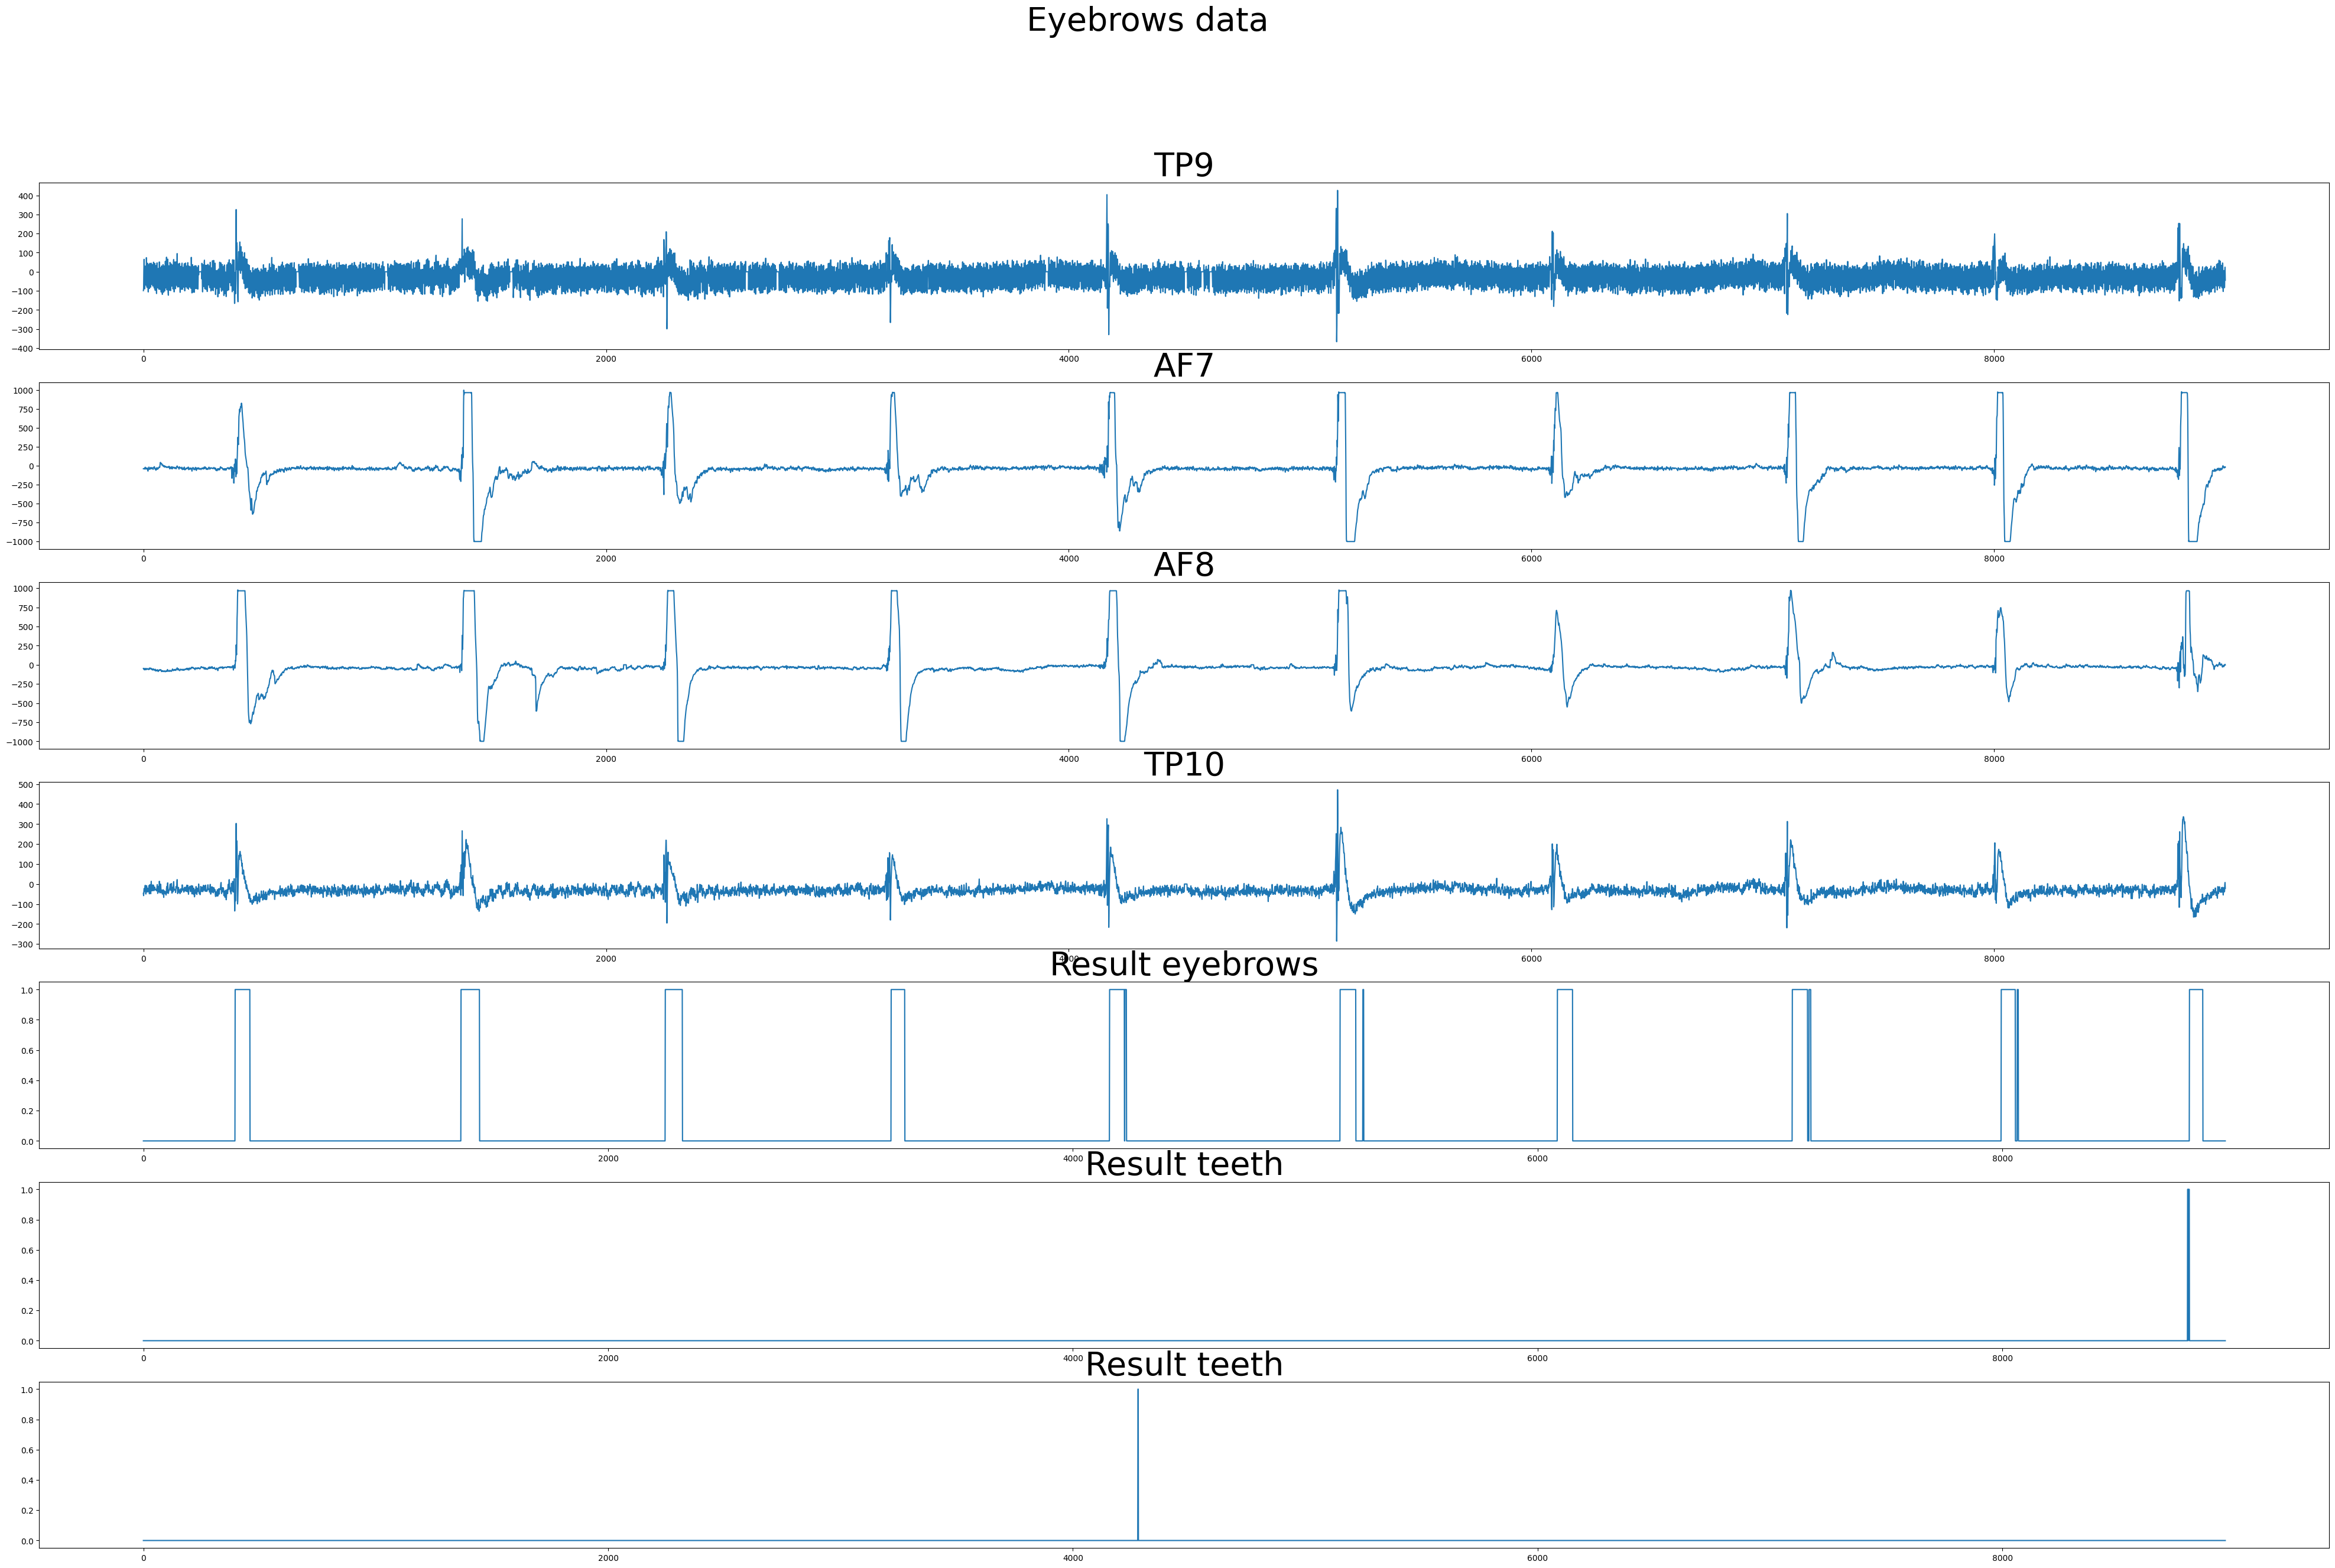

In [11]:
# eyebrows inference dataset
data, input_data = get_input(df_eyebrows)
y_pred_onehot = get_output(input_data)
plot_data_result(data, y_pred_onehot, "Eyebrows data")

(60, 20, 128, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
[0 2]


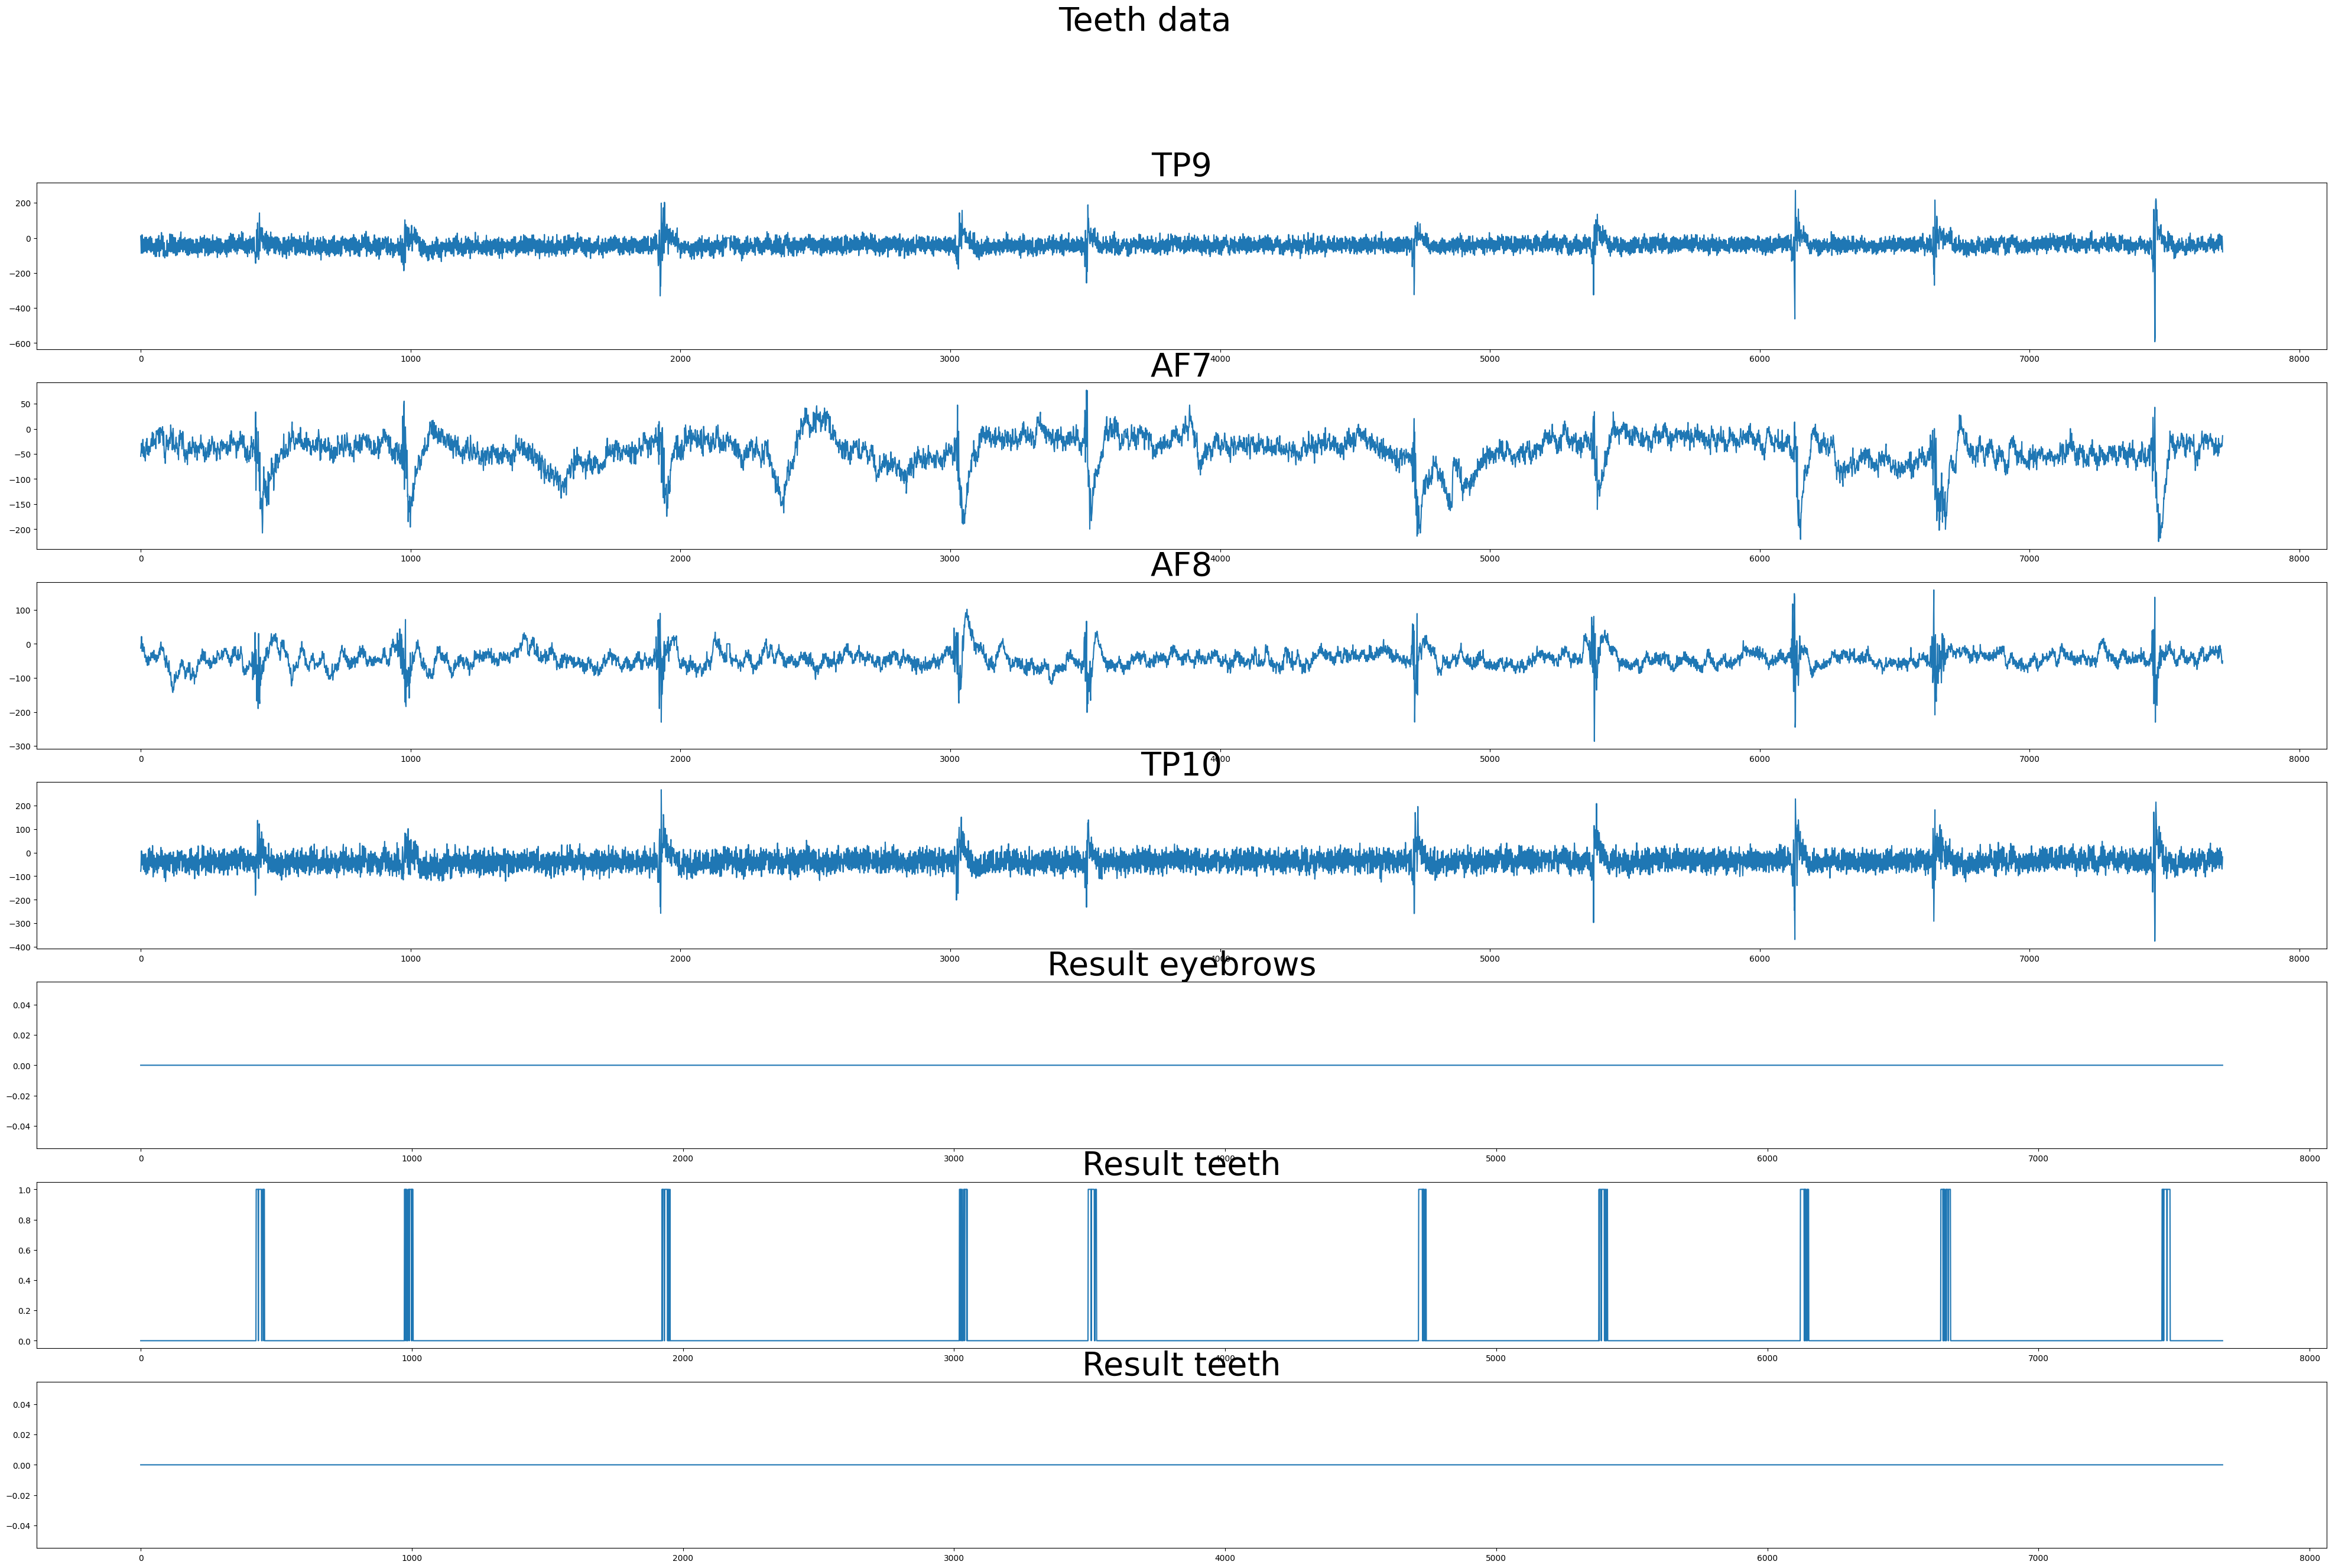

In [12]:
# teeth inference dataset
data, input_data = get_input(df_teeth)
y_pred_onehot = get_output(input_data)
plot_data_result(data, y_pred_onehot, "Teeth data")

(70, 20, 128, 1)
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[0 3]


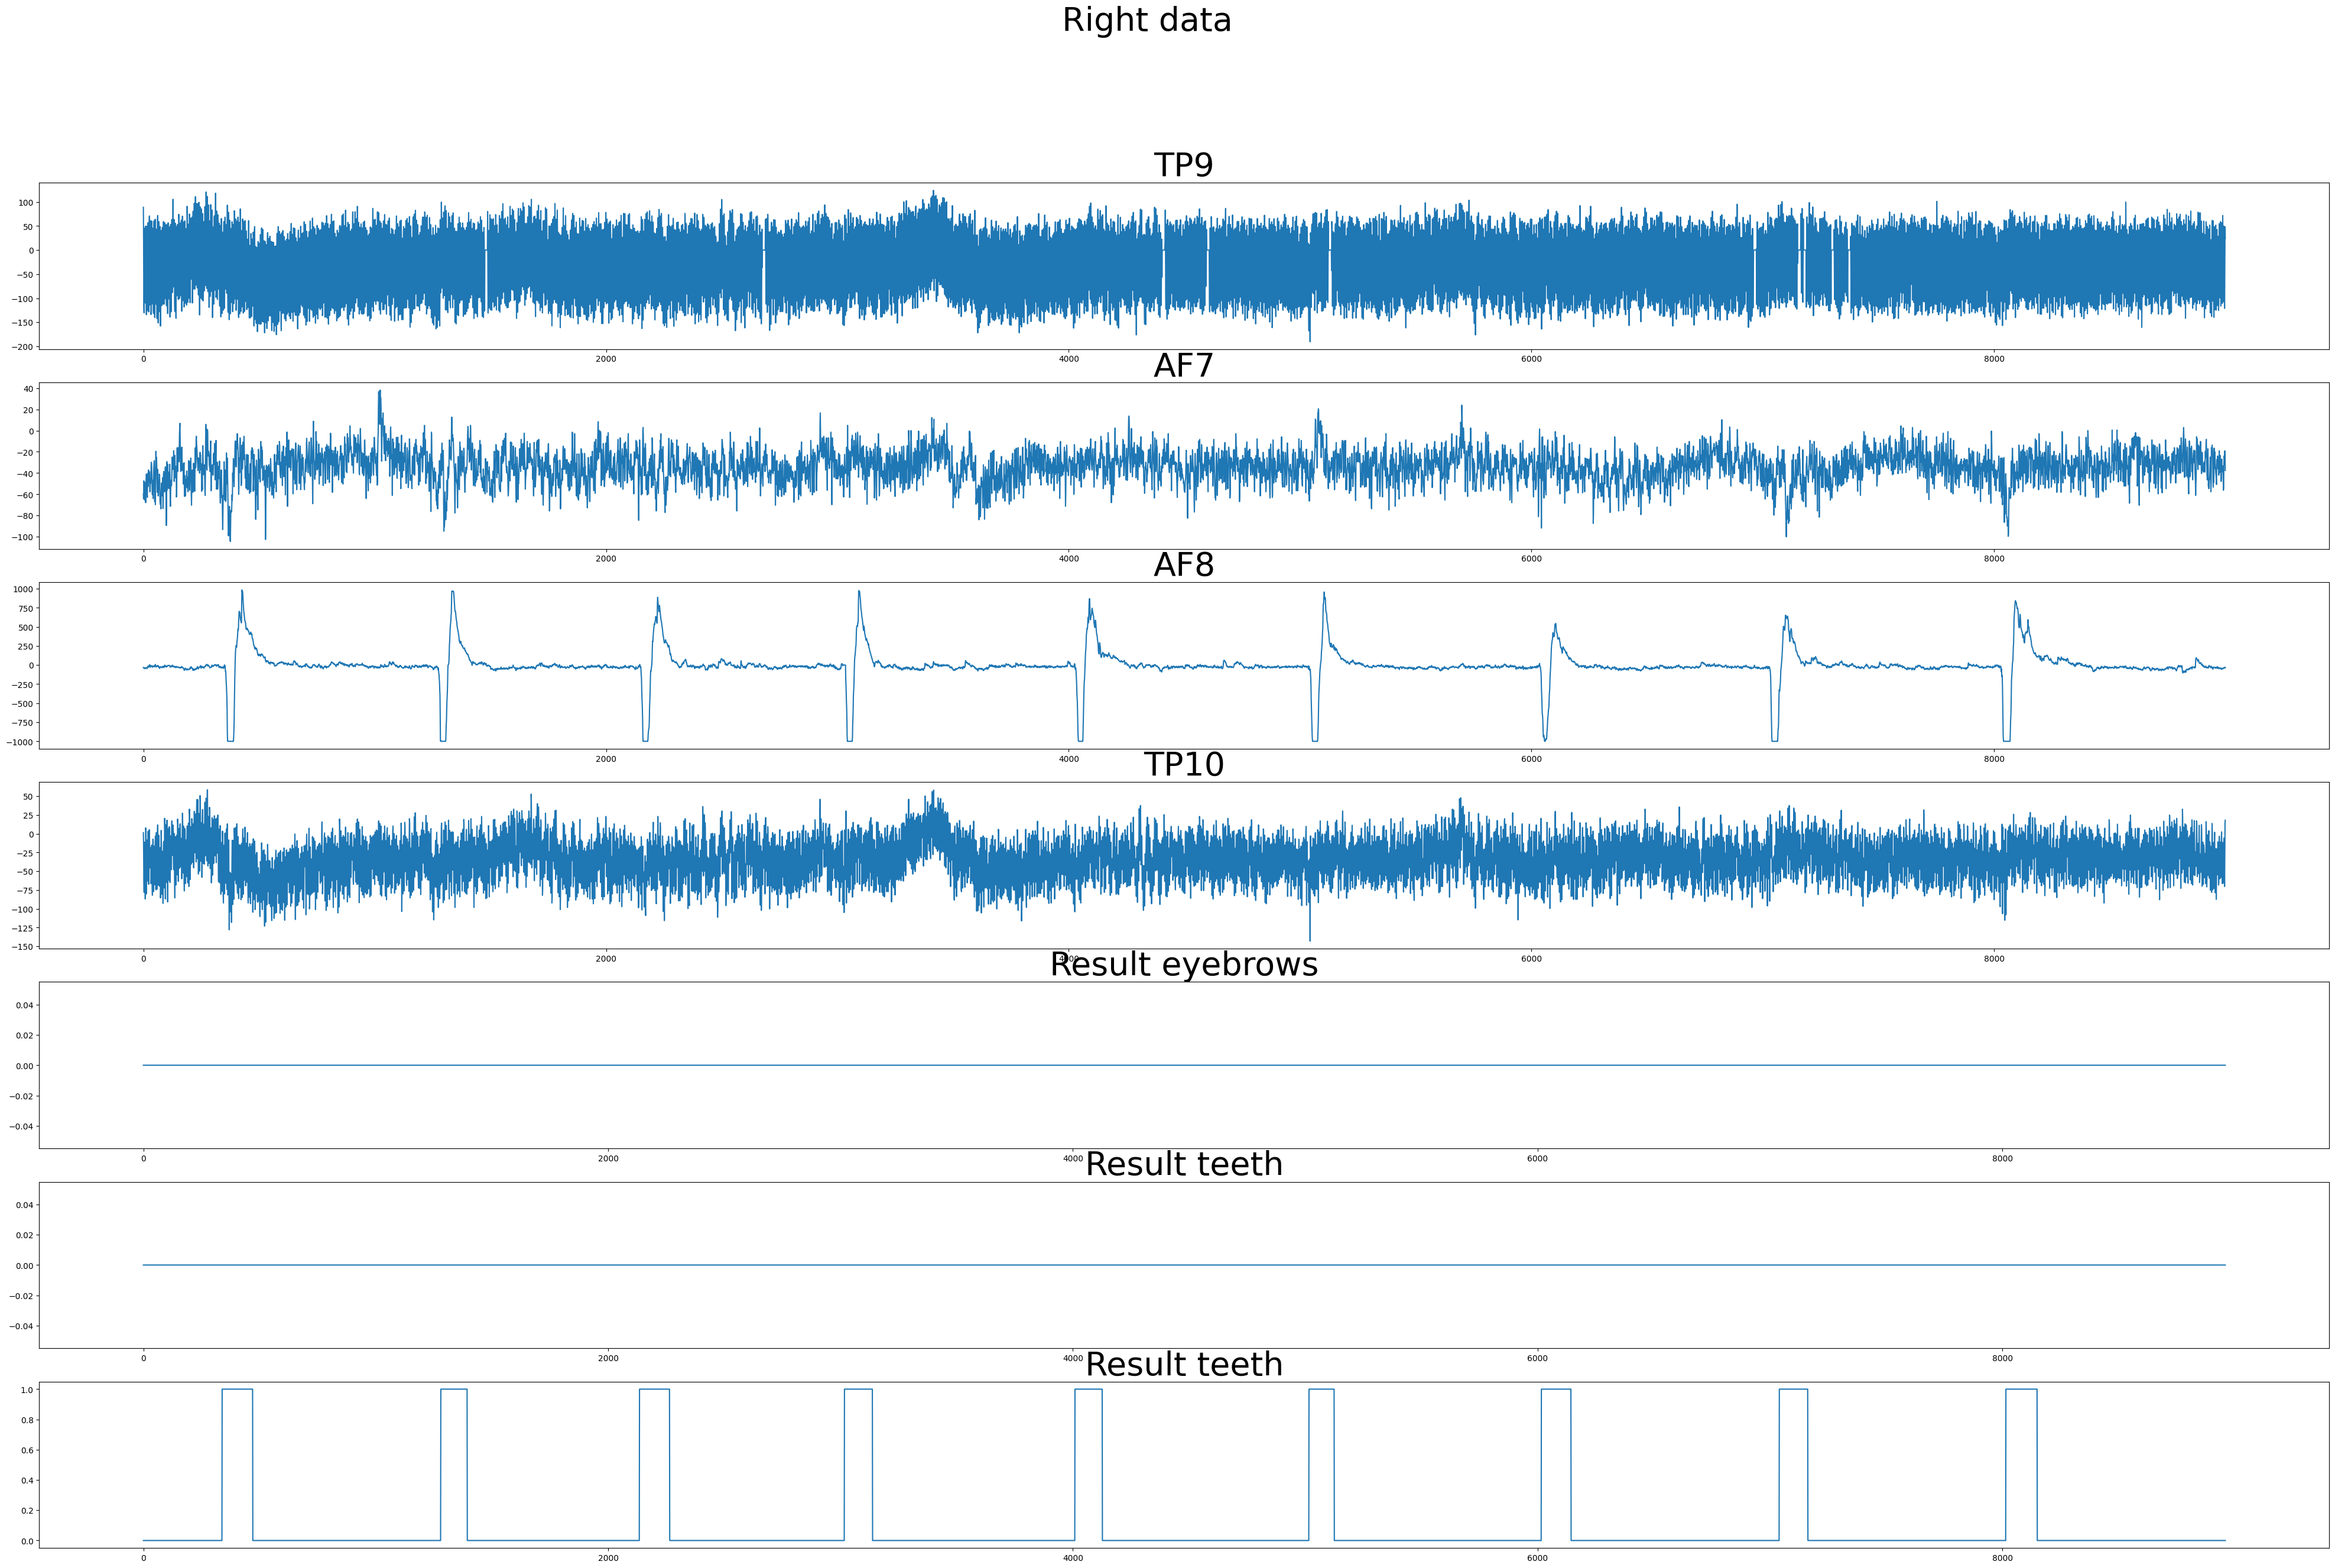

In [16]:
#  right dataset
data, input_data = get_input(df_right)
y_pred_onehot = get_output(input_data)
plot_data_result(data, y_pred_onehot, "Right data")

(70, 20, 128, 1)
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[0 1]


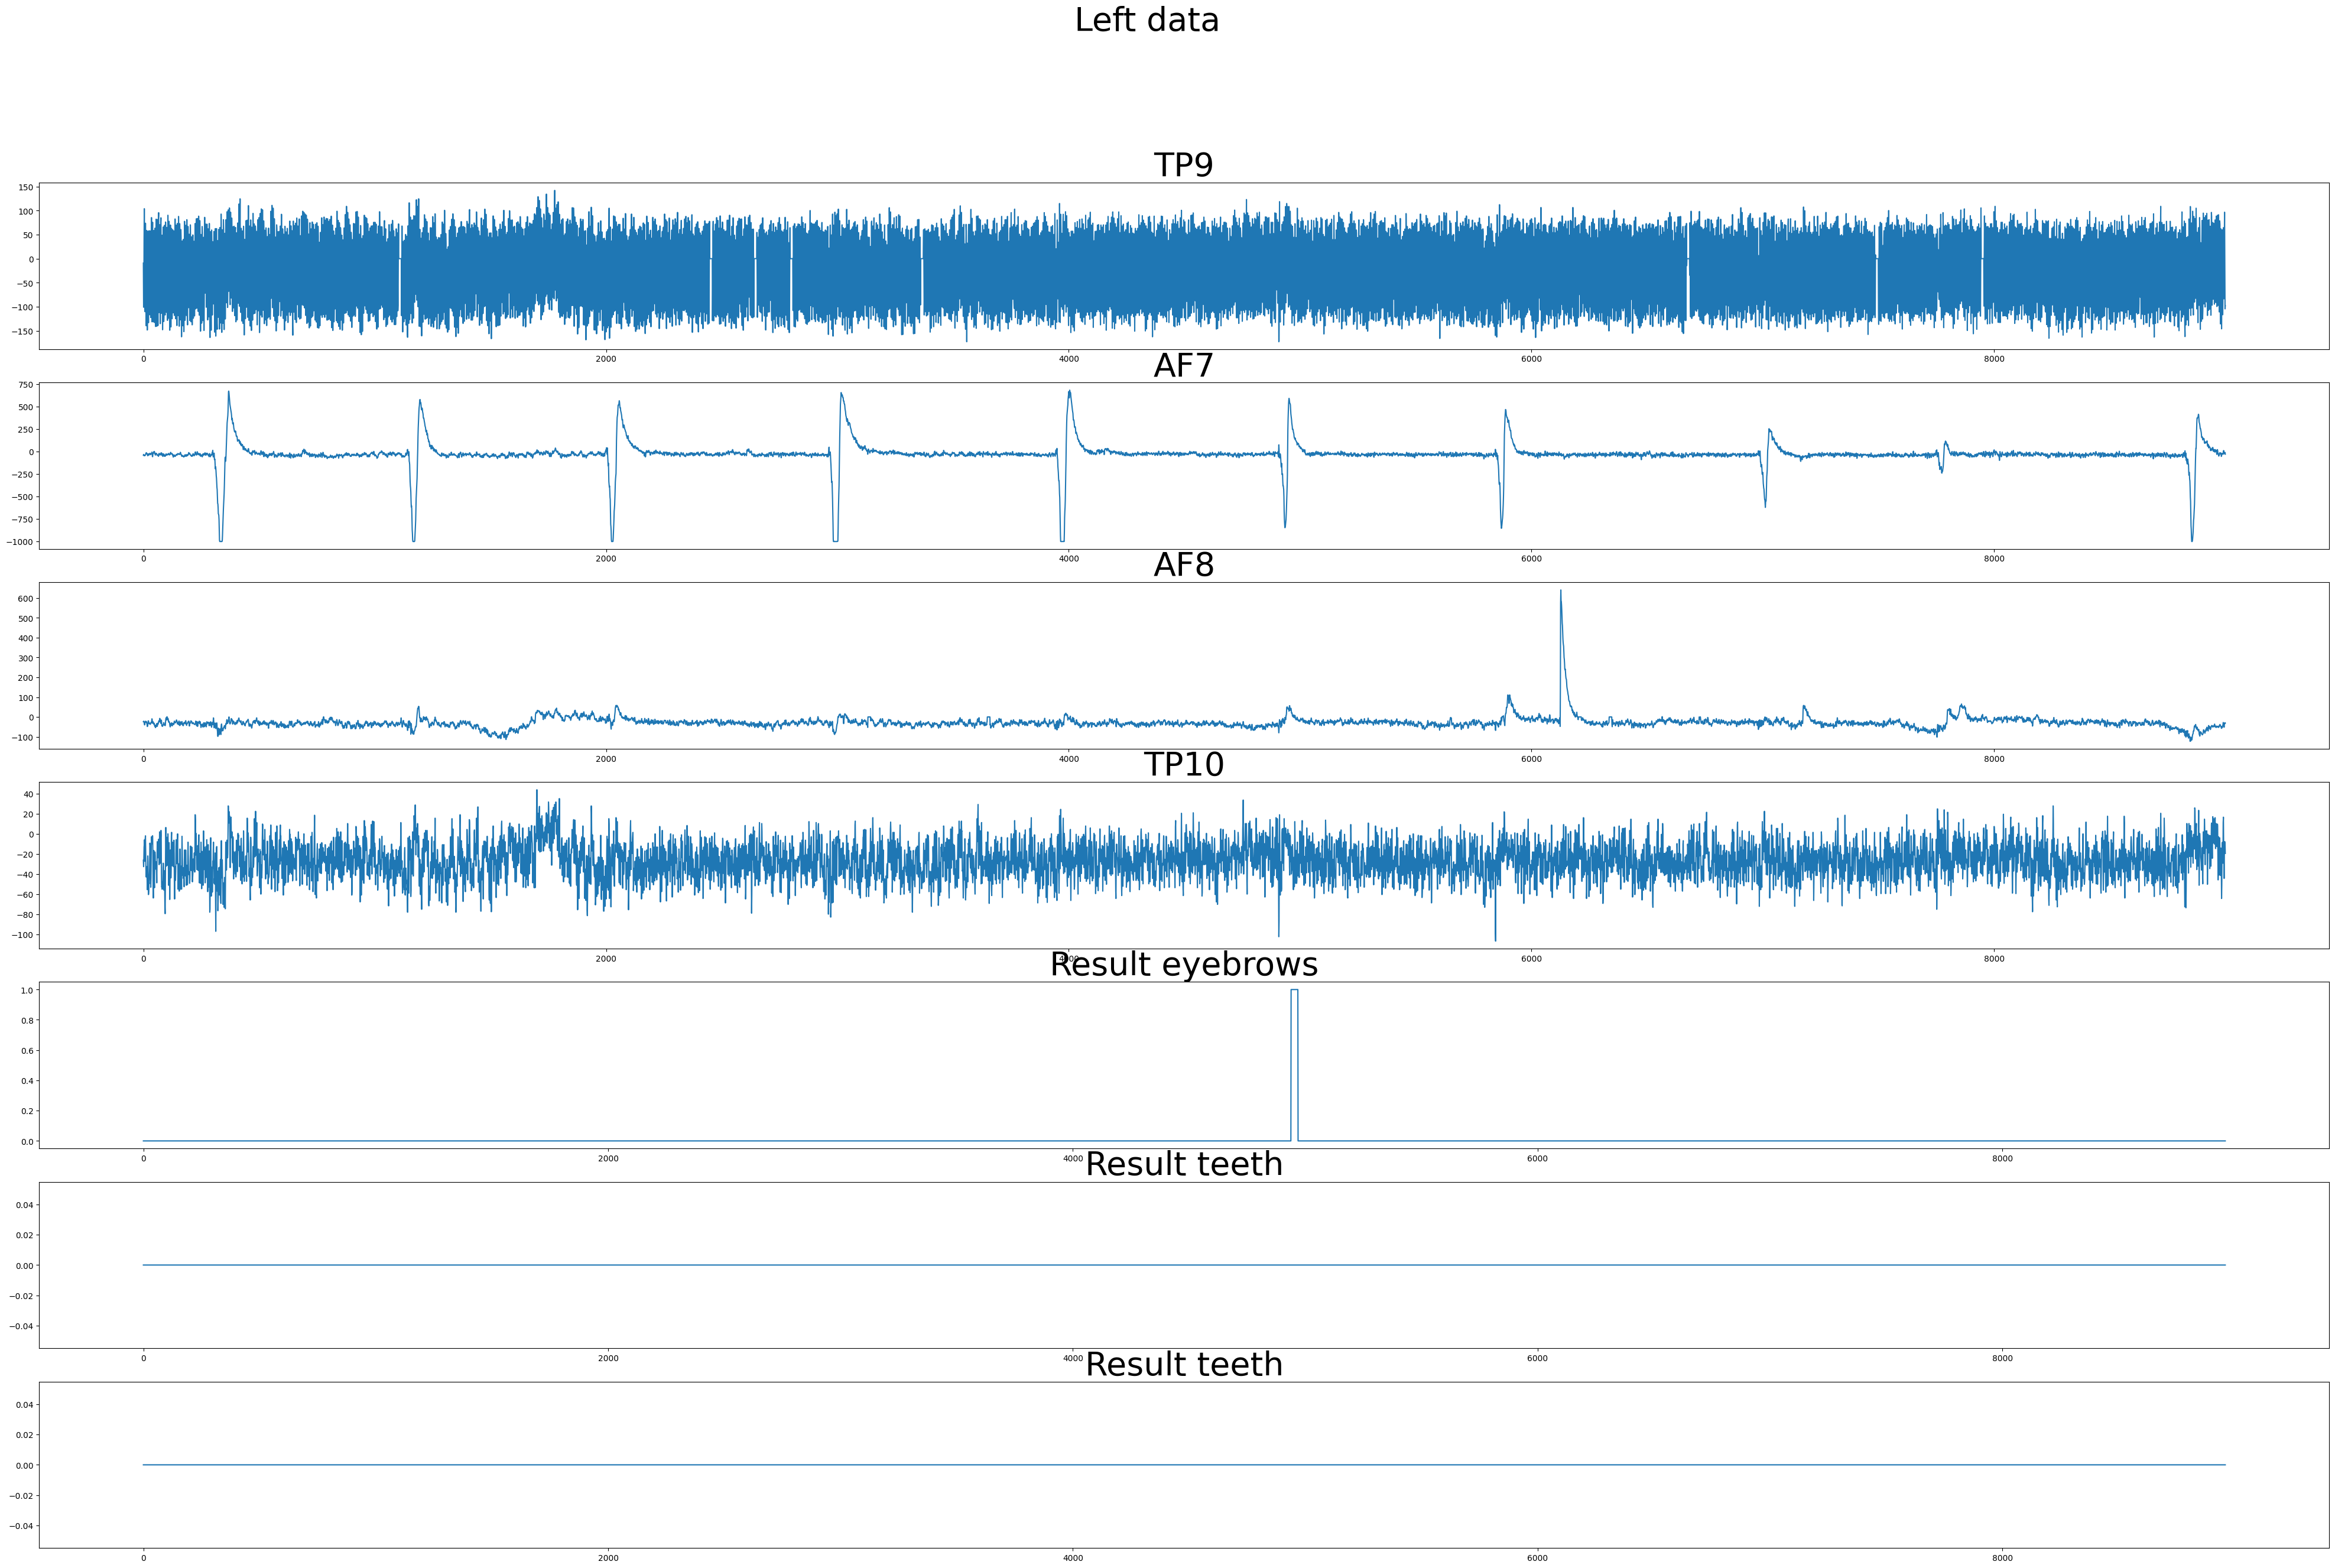

In [17]:
# left inference dataset
data, input_data = get_input(df_left)
y_pred_onehot = get_output(input_data)
plot_data_result(data, y_pred_onehot, "Left data")

(80, 20, 128, 1)
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[0]


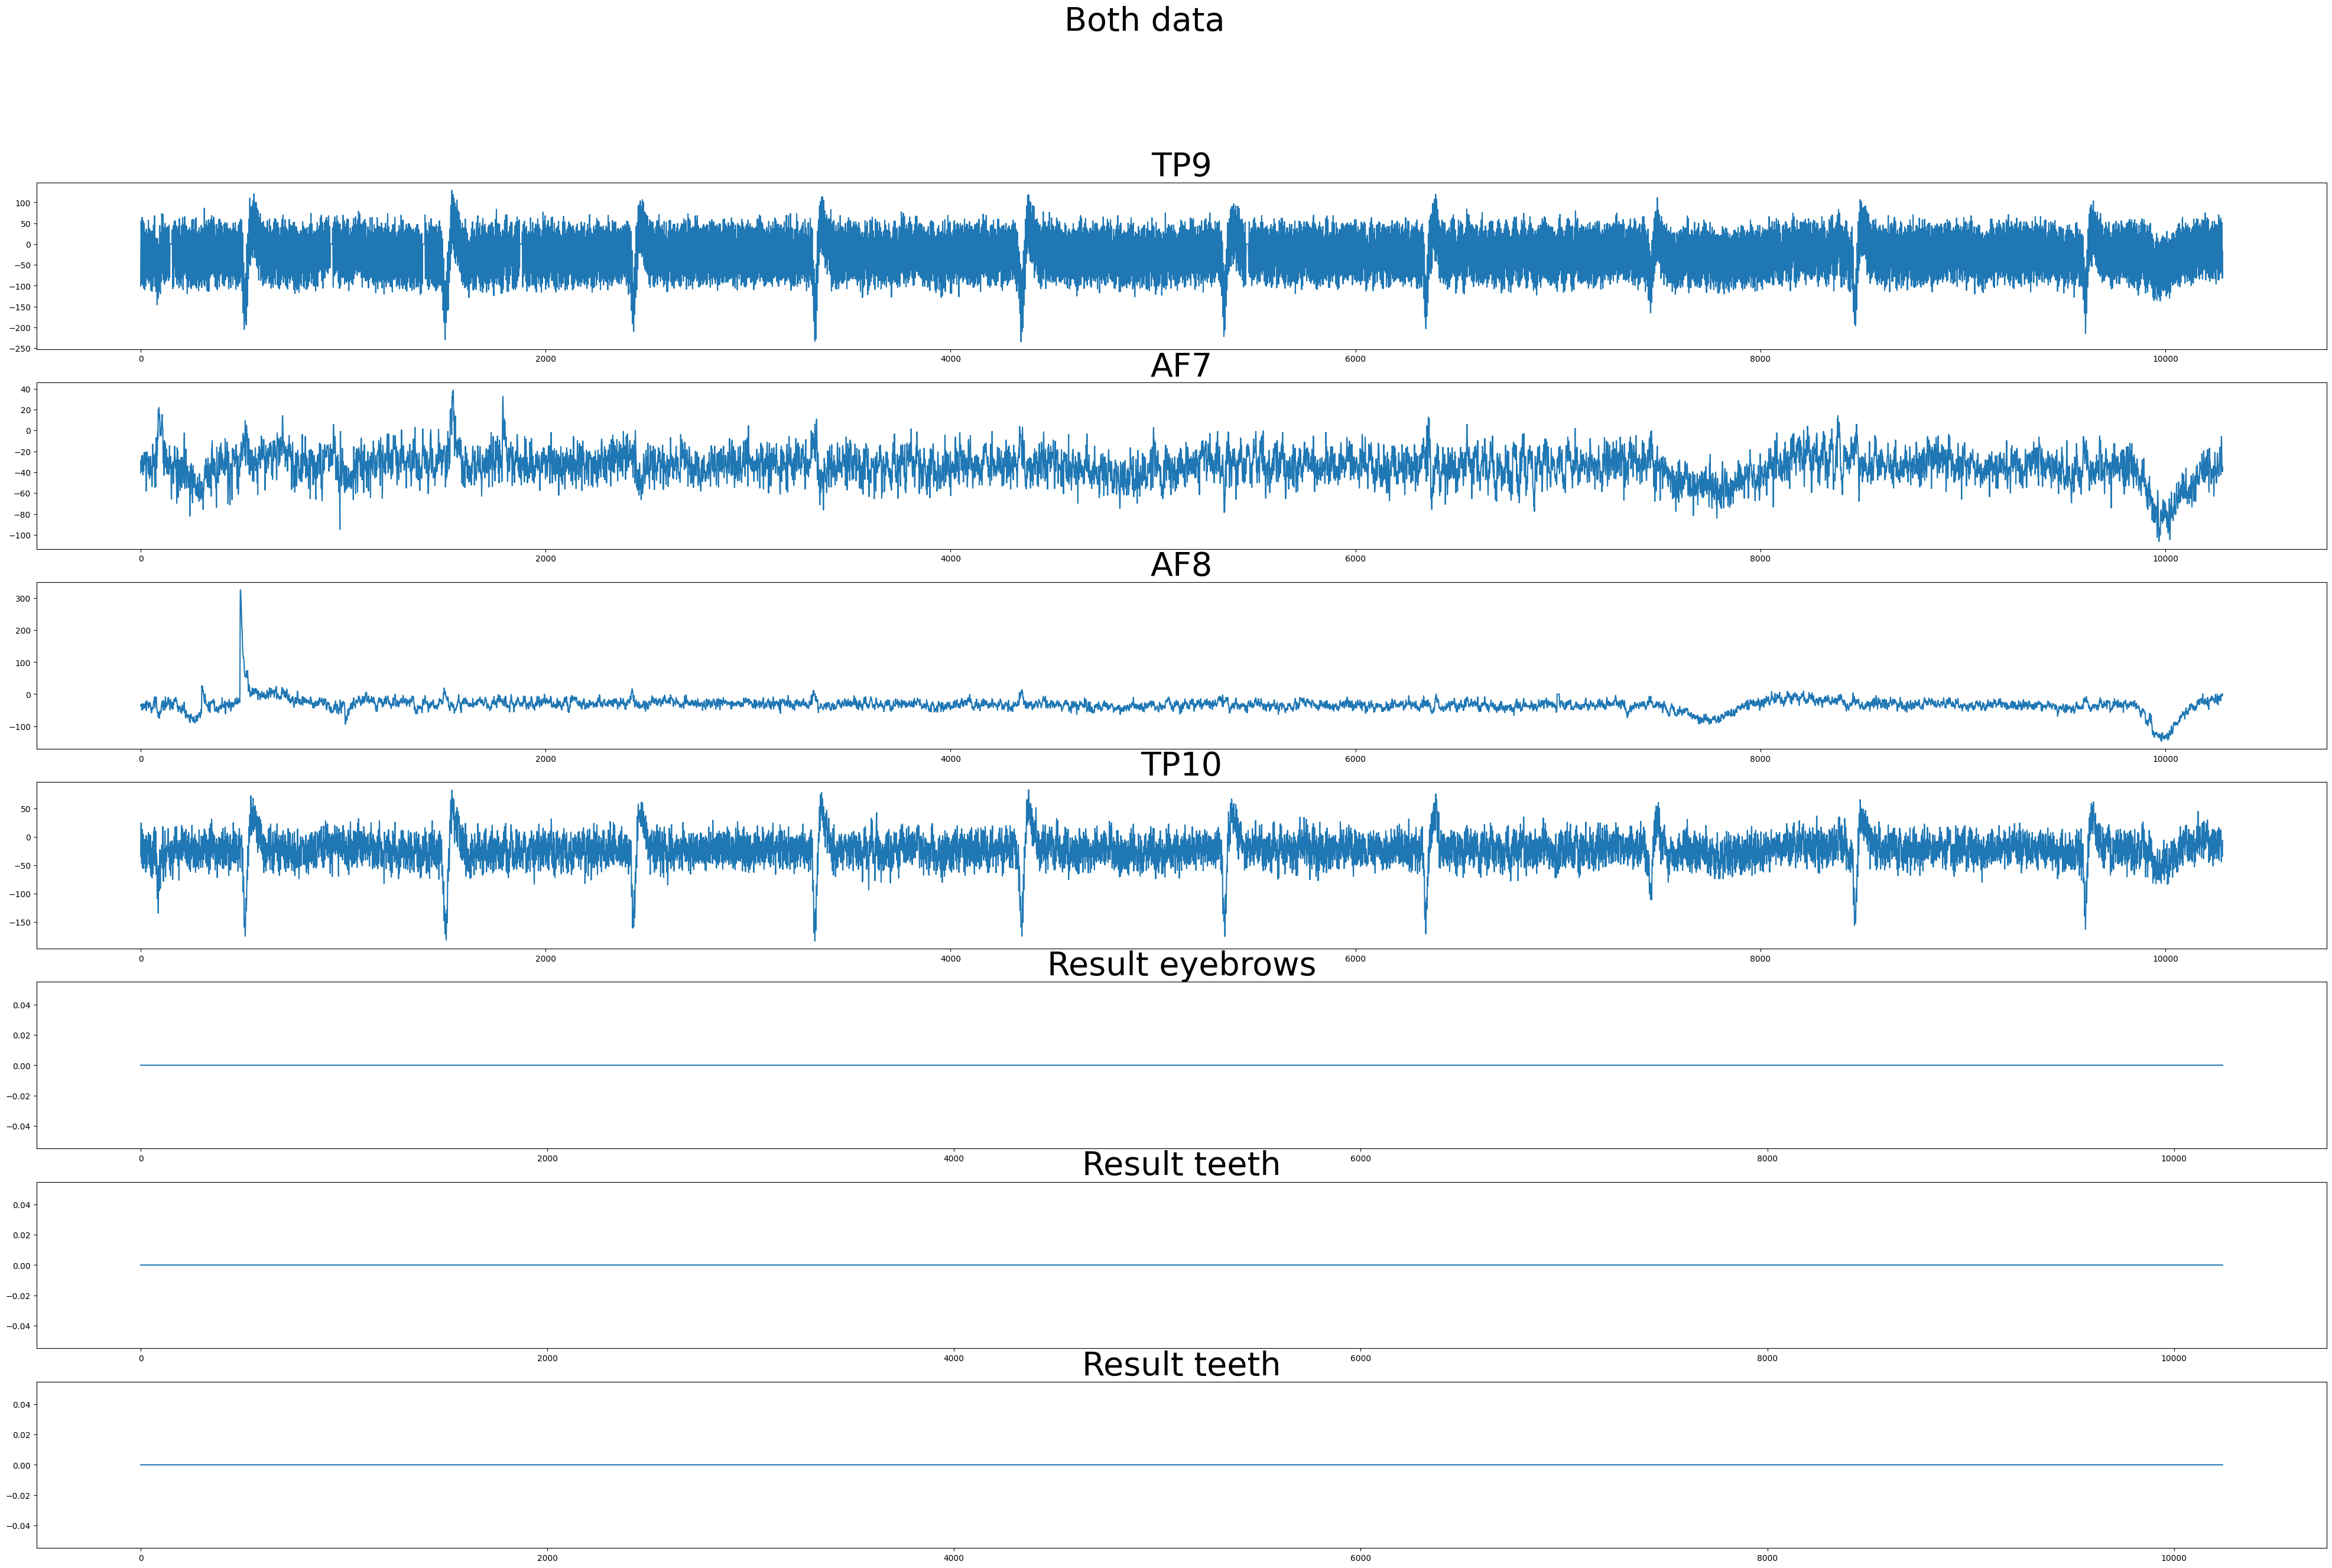

In [18]:
# both inference dataset
data, input_data = get_input(df_both)
y_pred_onehot = get_output(input_data)
plot_data_result(data, y_pred_onehot, "Both data")